# Cleaning of Training set

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils import resample
import seaborn as sns


In [26]:
training_data_path = 'C:\\Users\\qaism\\OneDrive - University of Virginia\\Documents\\Class Documents\\DS 3001\\group14\\project_2\\data\\training_data.csv'
training_data = pd.read_csv(training_data_path)

# Separate numeric and categorical columns
numeric_cols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
categorical_cols = ['gender', 'ever_married', 'Residence_type', 'work_type', 'smoking_status']

# Impute missing values for numeric columns
imputer = SimpleImputer(strategy='median')
training_data_numeric = pd.DataFrame(imputer.fit_transform(training_data[numeric_cols]), columns=numeric_cols)

# OneHotEncode categorical data
encoder = OneHotEncoder()
encoded_cats = encoder.fit_transform(training_data[categorical_cols])
encoded_cats_df = pd.DataFrame(encoded_cats.toarray(), columns=encoder.get_feature_names_out(categorical_cols))

# Combine numeric and categorical data
training_data_combined = pd.concat([training_data_numeric, encoded_cats_df], axis=1)

# Include 'stroke' column (target variable)
y = training_data['stroke']

In [27]:
# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(training_data_combined)

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the kNN model
knn = KNeighborsClassifier(n_neighbors=5)  # Start with k=5, adjust based on validation results
knn.fit(X_train, y_train)

# Validate the model
predictions = knn.predict(X_val)
print("Confusion Matrix:\n", confusion_matrix(y_val, predictions))
print("Classification Report:\n", classification_report(y_val, predictions))
print("Accuracy Score:", accuracy_score(y_val, predictions))

Confusion Matrix:
 [[777   6]
 [ 35   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       783
           1       0.00      0.00      0.00        35

    accuracy                           0.95       818
   macro avg       0.48      0.50      0.49       818
weighted avg       0.92      0.95      0.93       818

Accuracy Score: 0.9498777506112469


## Model Performance Summary

### Confusion Matrix Analysis:
- **True Negatives (777):** The model correctly predicted 777 instances where strokes did not occur.
- **False Positives (6):** The model incorrectly predicted 6 instances as strokes, which were actually non-stroke cases.
- **False Negatives (35):** The model failed to identify 35 actual stroke cases, predicting them as non-strokes.
- **True Positives (0):** The model did not correctly identify any true stroke cases.

### Classification Report Highlights:
- **Precision for Non-Stroke (0.96):** High precision indicates that the model's predictions of non-stroke are mostly correct.
- **Recall for Non-Stroke (0.99):** High recall shows the model is good at capturing the majority of actual non-stroke cases.
- **Precision for Stroke (0.00):** Very low precision for stroke cases suggests the model is not reliable in its positive stroke predictions.
- **Recall for Stroke (0.00):** Zero recall indicates the model failed to correctly identify any actual stroke cases.
- **F1-Score for Non-Stroke (0.97):** High F1-score for non-stroke predictions indicates a balance between precision and recall.
- **F1-Score for Stroke (0.00):** Zero F1-score for stroke predictions reflects poor performance in predicting actual stroke cases.

### Overall Accuracy:
- **Accuracy Score (94.98%):** While seemingly high, this accuracy is misleading due to the significant imbalance in the dataset, with a much larger number of non-stroke cases.

### Insights and Considerations:
- The model shows high accuracy in predicting non-stroke cases but fails completely in identifying stroke cases.
- This indicates a challenge with the imbalanced nature of the dataset, where stroke cases are much rarer.
- Future model adjustments should focus on techniques to handle imbalanced datasets and improve the detection of the minority class (stroke cases).



In [28]:
# Oversampling the minority class (stroke cases)
stroke_data = training_data[training_data.stroke == 1]
non_stroke_data = training_data[training_data.stroke == 0]

# Upsample the stroke cases
stroke_upsampled = resample(stroke_data, 
                            replace=True,     # sample with replacement
                            n_samples=len(non_stroke_data),    # to match majority class
                            random_state=123) # reproducible results

# Combine majority class with upsampled minority class
balanced_data = pd.concat([non_stroke_data, stroke_upsampled])

# Splitting the balanced data
X_balanced = balanced_data.drop('stroke', axis=1)
y_balanced = balanced_data['stroke']
X_train_balanced, X_val_balanced, y_train_balanced, y_val_balanced = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

In [29]:
#Impute missing values for numeric columns in the balanced dataset
X_train_balanced_numeric = pd.DataFrame(imputer.fit_transform(X_train_balanced[numeric_cols]), columns=numeric_cols)
X_val_balanced_numeric = pd.DataFrame(imputer.transform(X_val_balanced[numeric_cols]), columns=numeric_cols)

# OneHotEncode categorical data in the balanced dataset
X_train_balanced_categorical = X_train_balanced[categorical_cols]
X_val_balanced_categorical = X_val_balanced[categorical_cols]
encoded_train_cats = encoder.transform(X_train_balanced_categorical)
encoded_train_cats_df = pd.DataFrame(encoded_train_cats.toarray(), columns=encoder.get_feature_names_out(categorical_cols))
encoded_val_cats = encoder.transform(X_val_balanced_categorical)
encoded_val_cats_df = pd.DataFrame(encoded_val_cats.toarray(), columns=encoder.get_feature_names_out(categorical_cols))

# Combine numeric and categorical data for the balanced dataset
X_train_balanced_combined = pd.concat([X_train_balanced_numeric, encoded_train_cats_df], axis=1)
X_val_balanced_combined = pd.concat([X_val_balanced_numeric, encoded_val_cats_df], axis=1)

# Normalizing features for the balanced dataset
X_train_balanced_scaled = scaler.fit_transform(X_train_balanced_combined)
X_val_balanced_scaled = scaler.transform(X_val_balanced_combined)

# Retrain kNN model on balanced data
knn.fit(X_train_balanced_scaled, y_train_balanced)
balanced_predictions = knn.predict(X_val_balanced_scaled)

# Validate the retrained model
print("Confusion Matrix (Balanced Data):\n", confusion_matrix(y_val_balanced, balanced_predictions))
print("Classification Report (Balanced Data):\n", classification_report(y_val_balanced, balanced_predictions))


Confusion Matrix (Balanced Data):
 [[677  98]
 [  0 781]]
Classification Report (Balanced Data):
               precision    recall  f1-score   support

           0       1.00      0.87      0.93       775
           1       0.89      1.00      0.94       781

    accuracy                           0.94      1556
   macro avg       0.94      0.94      0.94      1556
weighted avg       0.94      0.94      0.94      1556



In [30]:
# Random Forest model on balanced data
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_balanced_scaled, y_train_balanced)
rf_predictions = rf_classifier.predict(X_val_balanced_scaled)

# Validate the Random Forest model
print("Random Forest Classifier Report:\n", classification_report(y_val_balanced, rf_predictions))


Random Forest Classifier Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       775
           1       0.98      1.00      0.99       781

    accuracy                           0.99      1556
   macro avg       0.99      0.99      0.99      1556
weighted avg       0.99      0.99      0.99      1556



In [31]:
# Gradient Boosting model on balanced data
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train_balanced_scaled, y_train_balanced)
gb_predictions = gb_classifier.predict(X_val_balanced_scaled)

# Validate the Gradient Boosting model
print("Gradient Boosting Classifier Report:\n", classification_report(y_val_balanced, gb_predictions))


Gradient Boosting Classifier Report:
               precision    recall  f1-score   support

           0       0.94      0.80      0.86       775
           1       0.83      0.94      0.88       781

    accuracy                           0.87      1556
   macro avg       0.88      0.87      0.87      1556
weighted avg       0.88      0.87      0.87      1556



In [32]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Grid search for Random Forest
rf_grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
rf_grid_search.fit(X_train_balanced_scaled, y_train_balanced)

# Best parameters and revalidation
print("Best Parameters:", rf_grid_search.best_params_)
best_rf = rf_grid_search.best_estimator_
best_rf_predictions = best_rf.predict(X_val_balanced_scaled)
print("Random Forest Classifier Report (Best Params):\n", classification_report(y_val_balanced, best_rf_predictions))


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Classifier Report (Best Params):
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       775
           1       0.99      1.00      0.99       781

    accuracy                           0.99      1556
   macro avg       0.99      0.99      0.99      1556
weighted avg       0.99      0.99      0.99      1556



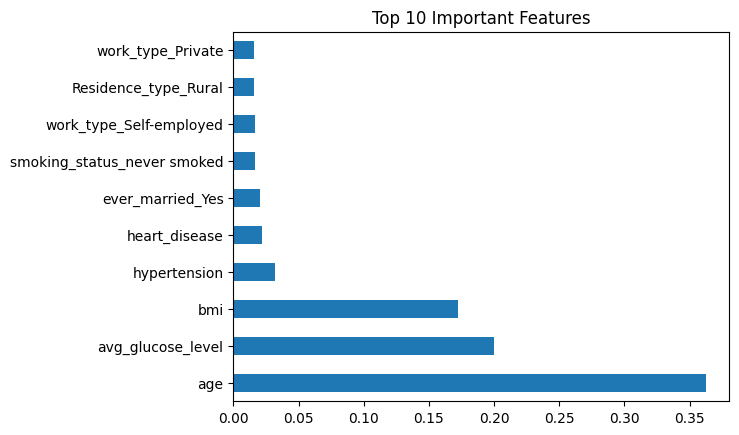

In [33]:
import matplotlib.pyplot as plt

# Feature importance
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train_balanced_combined.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Important Features')
plt.show()


## Feature Importance and Model Evaluation

- The Random Forest classifier identified **age** and **average glucose level** as the most influential features for stroke prediction.
- **BMI**, **hypertension**, and **heart disease** also showed substantial importance, aligning with medical literature on stroke risk factors.
- The model achieved a precision and recall of 0.99 after hyperparameter tuning, indicating a highly effective classifier on the balanced training dataset.

### Best Model Performance
- **Best Parameters:** Max Depth: 20, Min Samples Split: 2, Estimators: 200
- **Precision:** 0.99
- **Recall:** 0.99
- **F1-Score:** 0.99
- **Accuracy:** 99%

*Note: The above results are based on a balanced version of the training dataset. Further evaluation on an original distribution test set is recommended for real-world applicability.*


In [34]:
# Load the test dataset
test_data_path = 'C:\\Users\\qaism\\OneDrive - University of Virginia\\Documents\\Class Documents\\DS 3001\\group14\\project_2\\data\\testing_data.csv'
test_data = pd.read_csv(test_data_path)

# Separate test data into numeric and categorical columns
test_data_numeric = test_data[numeric_cols]
test_data_categorical = test_data[categorical_cols]

# Impute missing values for numeric columns in the test data
test_data_numeric_imputed = pd.DataFrame(imputer.transform(test_data_numeric), columns=numeric_cols)

# OneHotEncode categorical data in the test dataset (using the same encoder fitted on the training data)
encoded_test_cats = encoder.transform(test_data_categorical)
encoded_test_cats_df = pd.DataFrame(encoded_test_cats.toarray(), columns=encoder.get_feature_names_out(categorical_cols))

# Combine numeric and categorical data for the test dataset
test_data_combined = pd.concat([test_data_numeric_imputed, encoded_test_cats_df], axis=1)

# Normalize features for the test dataset (using the same scaler fitted on the training data)
test_data_scaled = scaler.transform(test_data_combined)


In [35]:
# Use the best model from GridSearchCV (assuming it's stored in `best_rf`)
test_predictions = best_rf.predict(test_data_scaled)

# Evaluate on the test data
test_true_labels = test_data['stroke']  # Replace with the actual column name for stroke labels in your test dataset
print("Test Set Classification Report:\n", classification_report(test_true_labels, test_predictions))


Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       973
           1       0.20      0.06      0.09        50

    accuracy                           0.94      1023
   macro avg       0.58      0.52      0.53      1023
weighted avg       0.92      0.94      0.93      1023



In [36]:
# Impute missing BMI values using the median from the training data
imputer = SimpleImputer(strategy='median')
training_data['bmi'] = imputer.fit_transform(training_data[['bmi']])
test_data['bmi'] = imputer.transform(test_data[['bmi']])

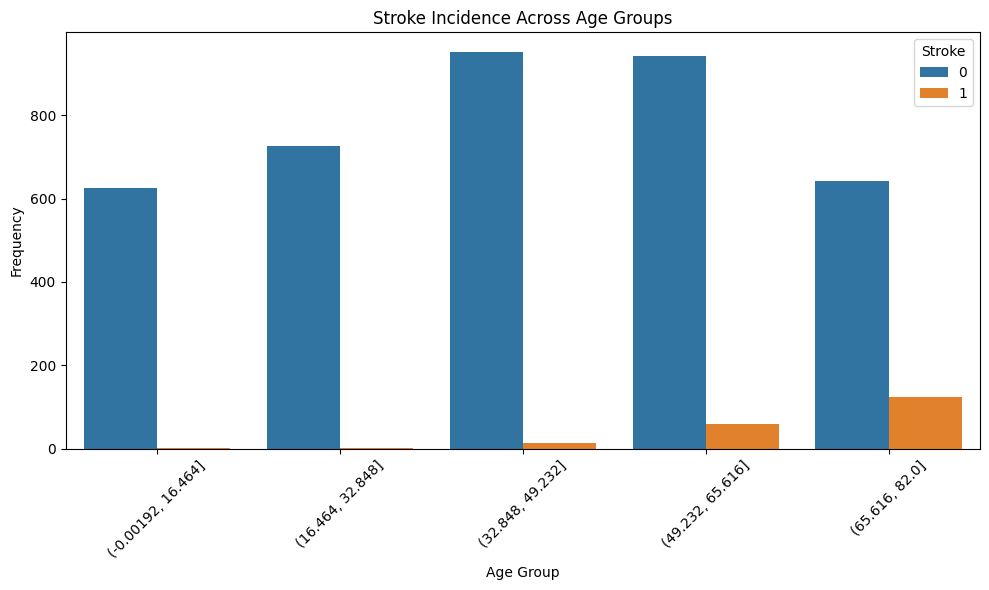

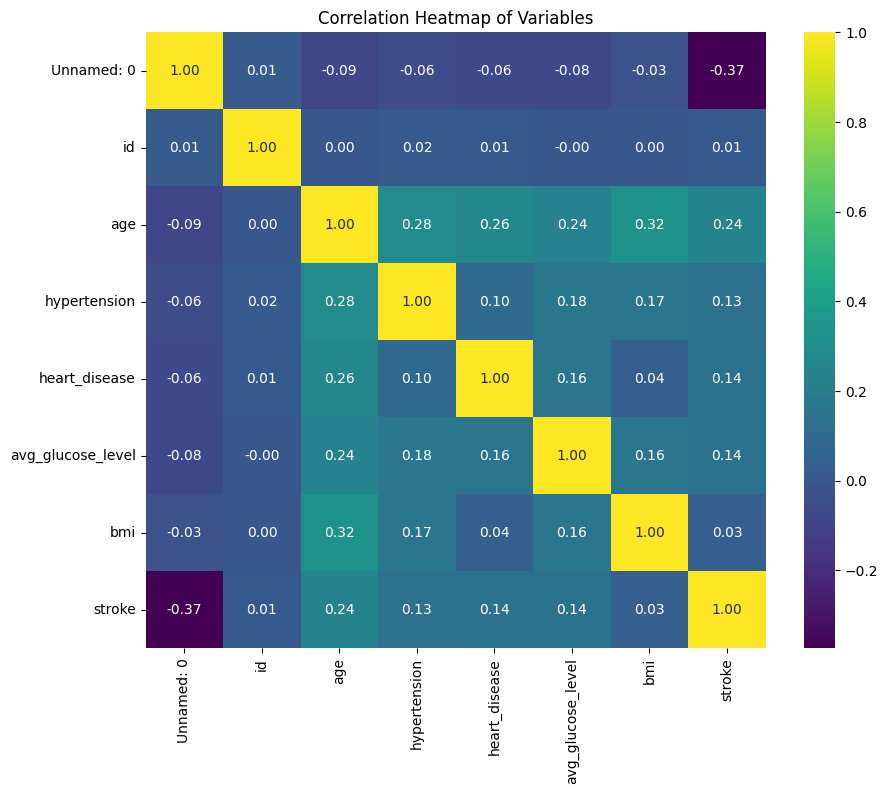

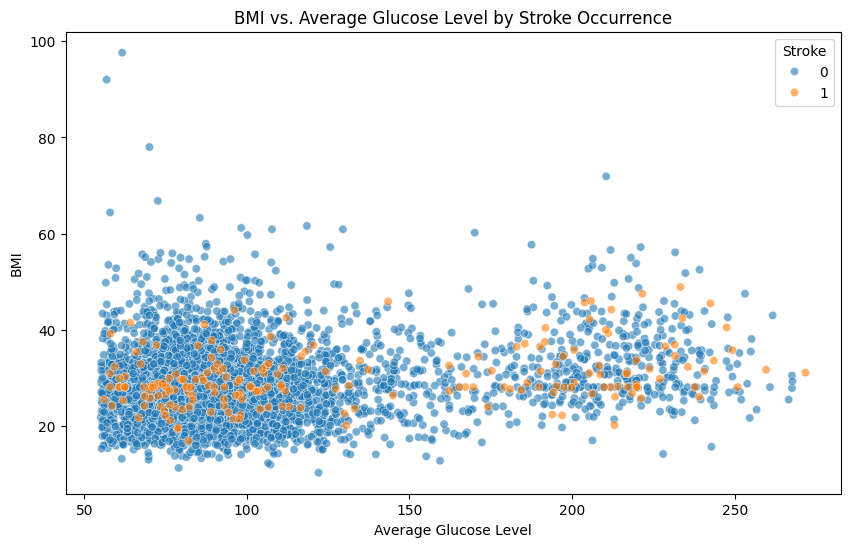

In [37]:
# Visualizations will be based on the training data after missing value imputation

# Bar chart showing the distribution of stroke incidents across different age groups
plt.figure(figsize=(10, 6))
sns.countplot(x=pd.cut(training_data['age'], bins=5), hue='stroke', data=training_data)
plt.title('Stroke Incidence Across Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend(title='Stroke')
plt.tight_layout()  # Adjust layout to fit the labels
plt.show()


numeric_data = training_data.select_dtypes(include=['float64', 'int64'])  # This selects only numeric columns

# Generate the correlation matrix for numeric data only
correlation_matrix = numeric_data.corr()

# Now you can safely plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='viridis')
plt.title('Correlation Heatmap of Variables')
plt.show()

# Scatter plot for BMI vs. Average Glucose Level, colored by stroke occurrence
plt.figure(figsize=(10, 6))
sns.scatterplot(x='avg_glucose_level', y='bmi', hue='stroke', data=training_data, alpha=0.6)
plt.title('BMI vs. Average Glucose Level by Stroke Occurrence')
plt.xlabel('Average Glucose Level')
plt.ylabel('BMI')
plt.legend(title='Stroke')
plt.show()


## Analysis Summary

Visualizations created from the cleaned and preprocessed data provided insights into the factors contributing to stroke incidence. Notably:

- **Age and Stroke Incidence**: A bar chart depicting stroke incidents across age groups showed a clear trend of increased stroke occurrence with advancing age.
- **BMI and Glucose Levels**: A scatter plot correlating BMI with average glucose levels, categorized by stroke occurrence, indicated potential risk clusters that warrant further investigation.
- **Correlation Insights**: The heatmap revealed significant correlations, especially between age and stroke, suggesting age as a strong predictor, along with other notable correlations involving average glucose levels and BMI.

These visualizations and their resulting insights are critical in understanding the multifaceted nature of stroke risk and aid in the development of robust predictive models.
